# Exploring the data (Plitt & Giocomo 2021)

### `pynwb`
For more info on the `pynwb` package and the `NWB` format, see the [docs](https://pynwb.readthedocs.io/en/stable/). They include lots of tutorials and useful information for making the most of this format.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pynwb

## Set some basic parameters

In [2]:
filepath = Path("small", "sub-F2_ses-20190407T210000_behavior+ophys_small.nwb")

## Open the file for reading
For simplicity, we will just open the file to read it (without the context manager `with`).

In [3]:
read_io = pynwb.NWBHDF5IO(filepath, "r")
read_nwbfile = read_io.read()

### Quick look at the structure

In [4]:
read_nwbfile

root pynwb.file.NWBFile at 0x140453419692000
Fields:
  devices: {
    Microscope <class 'pynwb.device.Device'>
  }
  experiment_description: TwoTower_foraging
  experimenter: ['Mark Plitt']
  file_create_date: [datetime.datetime(2021, 3, 1, 12, 22, 28, 183494, tzinfo=tzoffset(None, -18000))]
  identifier: fe9f5897-186a-4033-9aa9-1d329ac3a1f0
  imaging_planes: {
    ImagingPlane <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Stanford University School of Medicine
  lab: GiocomoLab
  processing: {
    behavior <class 'pynwb.base.ProcessingModule'>,
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  session_description: TwoTower_foraging_001_011
  session_start_time: 2019-04-07 21:00:00-07:00
  stimulus: {
    bckgndJitter <class 'pynwb.base.TimeSeries'>,
    morph <class 'pynwb.base.TimeSeries'>,
    reward <class 'pynwb.base.TimeSeries'>,
    towerJitter <class 'pynwb.base.TimeSeries'>,
    wallJitter <class 'pynwb.base.TimeSeries'>
  }
  subject: subject pynwb.file.Subject at

## Main data types

### General info

In [5]:
print("Subject info:")
for key, value in read_nwbfile.subject.fields.items():
    print(f"    {key:13}: {value}")

print("\nSession info:")    
print(f"    date/time  : {read_nwbfile.session_start_time}")
print(f"    description: {read_nwbfile.session_description}")

Subject info:
    genotype     : CaMKII-cre hemizygous
    sex          : MALE
    species      : Mus musculus
    subject_id   : F2
    weight       : 29.3 g
    date_of_birth: 2019-01-16 21:00:00-08:00

Session info:
    date/time  : 2019-04-07 21:00:00-07:00
    description: TwoTower_foraging_001_011


### Imaging plane
We can see what the imaging plane looked like, and even which neurons were identified.

In [6]:
def plot_plane(data):
    # plot
    fig, ax = plt.subplots()
    ax.imshow(data.T, cmap="Greys_r")

    # aesthetics
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

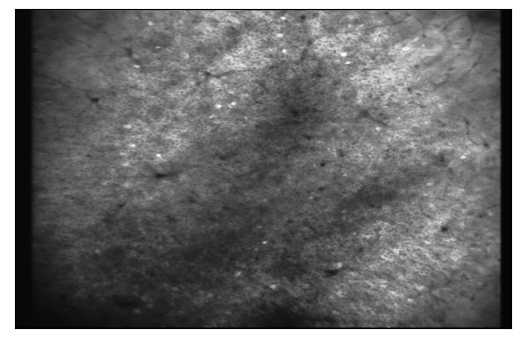

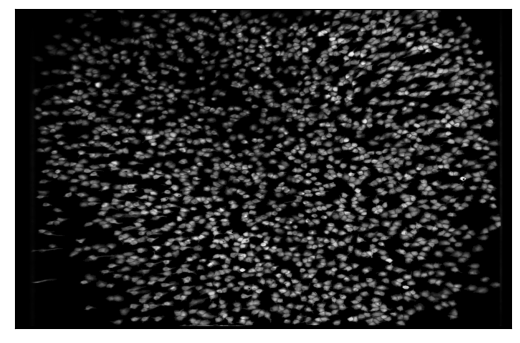

In [7]:
# plot the imaging plane
imaging_plane = read_nwbfile.processing["ophys"]["SegmentationImages"].images["mean"][()]
plot_plane(imaging_plane)

# plot the ROI masks (takes a bit of time to load!)
masks_flat = read_nwbfile.processing["ophys"]["ImageSegmentation"]["PlaneSegmentation"]["image_mask"].data[()].max(axis=0)
plot_plane(masks_flat);

### ROI response series

In [8]:
ROI_traces = read_nwbfile.processing["ophys"]["Fluorescence"]["RoiResponseSeries"].data
print("{} frames x {} neurons".format(*ROI_traces.shape))

37840 frames x 1841 neurons


In [9]:
def normalize_and_plot(ROI_traces, num_plot=5):
    
    # select first N ROIs
    selected_ROI_traces = ROI_traces[:, : num_plot]
    
    # normalize each trace to between 0 and 1 for visualization
    maxes = selected_ROI_traces.max(keepdims=True)
    mins = selected_ROI_traces.min(keepdims=True)
    norm_responses = (selected_ROI_traces - mins) / (maxes - mins)
    
    # separate the traces in the y axis, so they don't overlap when plotted
    norm_responses_shifted = norm_responses + np.arange(num_plot).reshape(1, -1) * 1.1
    
    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(norm_responses_shifted, alpha=0.8, color="k", lw=1)
    ax.set_title("Normalized ROI reponses")
    ax.set_xlabel("Frames")
    
    # aesthetics
    ax.yaxis.set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

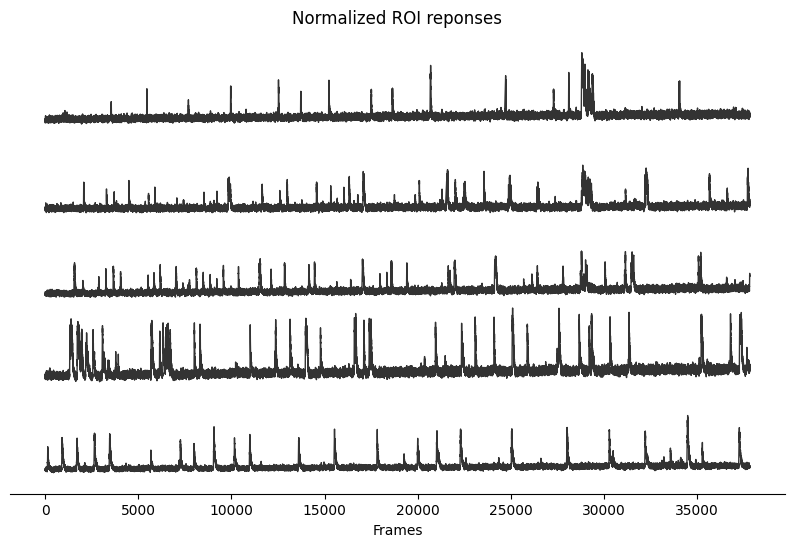

In [10]:
# for a quick visualization, we can plot a few ROIs, each normalized and separated so they don't overlap
normalize_and_plot(ROI_traces);

### Behaviour

In [11]:
print("Behavioural data info:")
for key, value in read_nwbfile.processing["behavior"]["BehavioralTimeSeries"].time_series.items():
    print(f"    {key:9}: {value.description} ({len(value.data)} frames)")

Behavioural data info:
    dz       : (virtual cm) raw rotary encoder information (37840 frames)
    lick     : number of licks in 2P frame (37840 frames)
    lick rate: smooth version of no. licks (37840 frames)
    pos      : (virtual cm) position on virtual reality track (37840 frames)
    rzone    : information about collisions with objects in virtual track, 0-collision (37840 frames)
    speed    : mouse's speed on ball (37840 frames)
    teleport : information about collisions with objects in virtual track, 0-collision (37840 frames)
    tstart   : information about collisions with objects in virtual track, 0-collision (37840 frames)


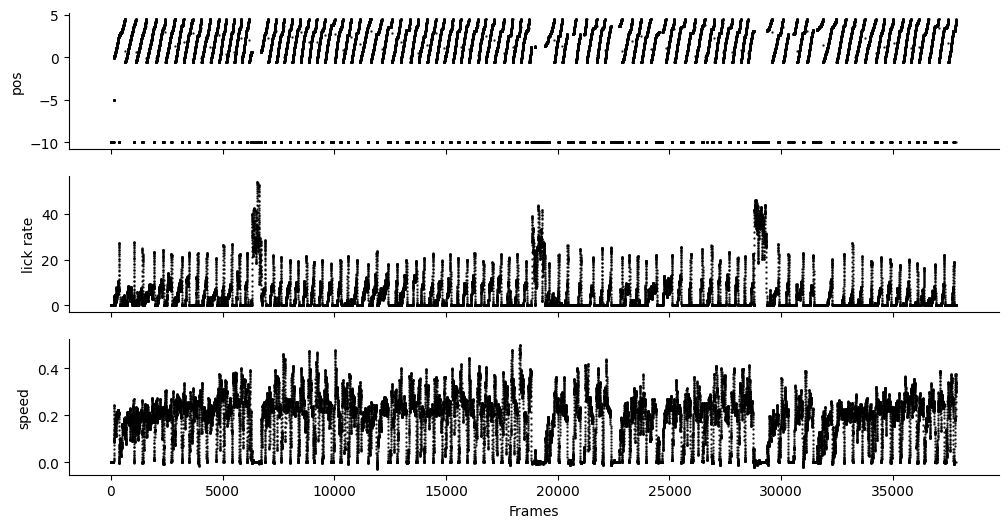

In [12]:
# plot some behavioral data
keys = ["pos", "lick rate", "speed"]
fig, ax = plt.subplots(len(keys), 1, figsize=[12, 6], sharex=True)

for k, key in enumerate(keys):
    data = read_nwbfile.processing["behavior"]["BehavioralTimeSeries"][key].data[()]

    # plot
    ax[k].plot(data, lw=0, marker=".", ms=1.5, color="k", alpha=0.8)
    ax[k].set_ylabel(key)

    # aesthetics
    for spine in ["top", "right"]:
        ax[k].spines[spine].set_visible(False)

ax[-1].set_xlabel("Frames");

### Stimulus

In [13]:
print("Stimulus data info:")
for key, value in read_nwbfile.stimulus.items():
    print(f"    {key:12}: {value.description} ({len(value.data)} frames)")

Stimulus data info:
    bckgndJitter: information about stimulus in arbitrary units (37840 frames)
    morph       : information about stimulus in arbitrary units (37840 frames)
    reward      : number of rewards dispensed  (37840 frames)
    towerJitter : information about stimulus in arbitrary units (37840 frames)
    wallJitter  : information about stimulus in arbitrary units (37840 frames)


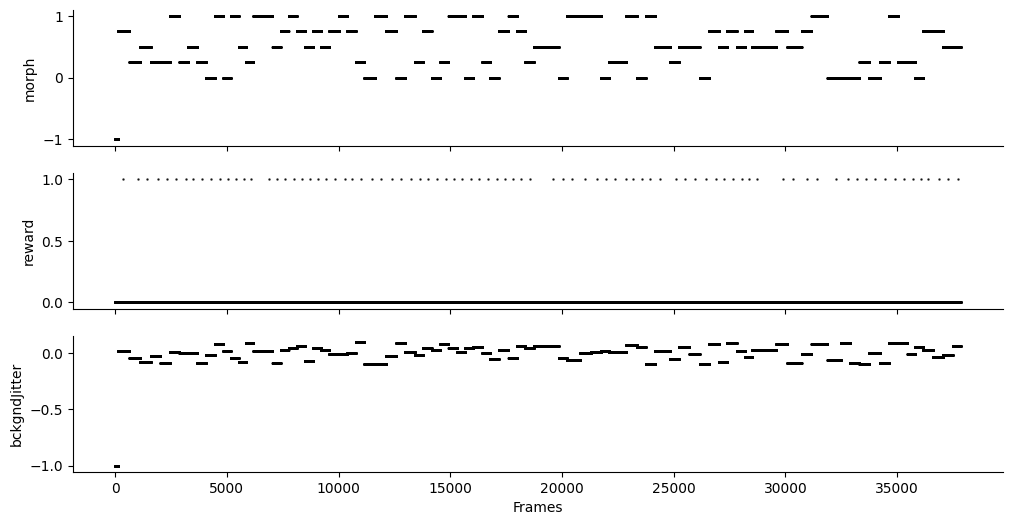

In [14]:
# plot some stimulus data
keys = ["morph", "reward", "bckgndJitter"]
fig, ax = plt.subplots(len(keys), 1, figsize=[12, 6], sharex=True)

for k, key in enumerate(keys):
    data = read_nwbfile.stimulus[key].data[()]

    # plot
    ax[k].plot(data, lw=0, marker=".", ms=1.5, color="k", alpha=0.8)
    ax[k].set_ylabel(key)

    # aesthetics
    for spine in ["top", "right"]:
        ax[k].spines[spine].set_visible(False)

ax[-1].set_xlabel("Frames");

## End
I suppose to be absolutely correct, we should technically close our file when we are done... But that is very annoying in a jupyter notebook where cells are often run out of order! So I'll leave it commented out.

In [15]:
# read_io.close()